In [0]:
!pip install tensorflow-gpu==2.0.0

In [0]:
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten
from tensorflow.keras import applications

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2

---
## Datasets
lets download our dataset from this repo release page

In [0]:
!wget https://github.com/pradiptaagus/FishRecognition/releases/download/dataset-v0.1/data_train.npy
!wget https://github.com/pradiptaagus/FishRecognition/releases/download/dataset-v0.1/data_train_label.npy

### Now load the datasets

In [12]:
X_train = np.load('data_train.npy')
y_train = np.load('data_train_label.npy')
labels = ['Kakap Merah', 'Gurame', 'Mujair', 'Nila', 'Tongkol']
print('Data train : ', X_train.shape)
print('Data label : ', y_train.shape)
print('Labels : ', labels)

Data train :  (66, 224, 224, 3)
Data label :  (66, 5)
Labels :  ['Kakap Merah', 'Gurame', 'Mujair', 'Nila', 'Tongkol']


### Let's show some of our datasets

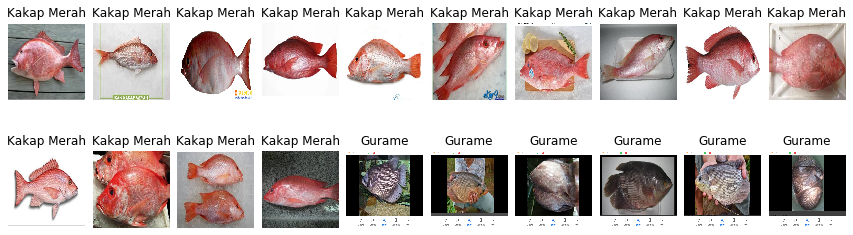

In [13]:
fig, ax = plt.subplots(2,10,figsize=(15,4.5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for j in range(0,2):
    for i in range(0, 10):
        ax[j,i].imshow(X_train[i+j*10])
        ax[j,i].set_title(labels[np.argmax(y_train[i+j*10])])
        ax[j,i].axis('off')
plt.show()

---
## Preprocessing Datasets

In [0]:
new_X_train = []
for x in X_train:
  img = applications.mobilenet_v2.preprocess_input(x)
  new_X_train.append(img)
new_X_train = np.array(new_X_train)

---
## Base Mobel (MobileNet)

In [9]:
base_model = applications.mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

9412608/9406464 [==============================] - 1s 0us/step


Because we will do transfer learning, freeze the base model 

In [0]:
base_model.trainable = False

---
## Build Model
add Global Average Pooling layer and last Dense layer

In [0]:
x = GlobalAveragePooling2D() (base_model.output)
x = Dense(len(labels), activation='softmax') (x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=x, name='fish_model')

In [18]:
model.summary()

Model: "fish_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_________________________________________________________________________________________

we can plot our model to better view

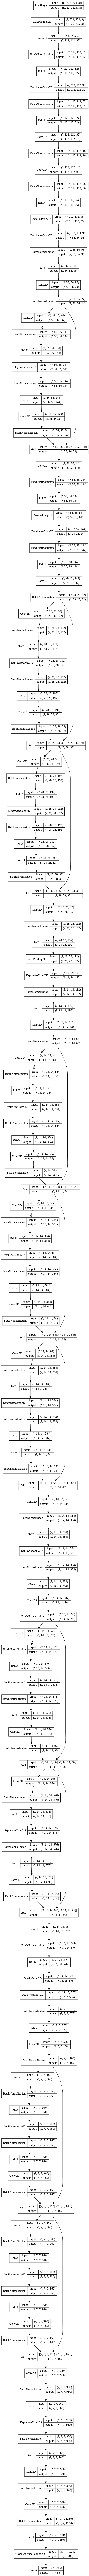

In [19]:
from tensorflow.keras.utils import plot_model
plot_model(model, 
           to_file='model.png', 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TD',
           dpi=70
          )

---
## Compile Our Model

In [0]:
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

---
## Let's Train Our Model

In [0]:
epochs = 1000
batch_size = 128
model.fit(new_X_train, y_train, epochs=epochs, batch_size=batch_size)

---
## Save Our Model

In [0]:
model.save("model.h5")

---
## Finaly Convert Our Model To TFLite

In [0]:
!tflite_convert --output_file=model_fish.tflite --keras_model_file=model.h5

Copyright Surya Mahadi 2020